<a href="https://colab.research.google.com/github/jessfeld/netpyne_course_2021/blob/main/netpyne_batch_tut8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neuron
!pip install netpyne
import matplotlib

     |████████████████████████████████| 12.6MB 302kB/s 
     |████████████████████████████████| 317kB 6.5MB/s 


In [ ]:
rm -r netpyne-course-2021

rm: cannot remove 'netpyne-course-2021': No such file or directory


In [ ]:

!git clone --single-branch --branch batch https://github.com/suny-downstate-medical-center/netpyne-course-2021.git


Cloning into 'netpyne-course-2021'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 68 (delta 12), reused 62 (delta 12), pack-reused 0
Unpacking objects: 100% (68/68), done.


In [ ]:
cd netpyne-course-2021

/content/netpyne-course-2021


In [ ]:
ls

tut8_analysis.py  tut8_batch.py  tut8_cfg.py  tut8_init.py  tut8_netParams.py


In [ ]:
from netpyne import specs, sim
%matplotlib inline
from netpyne import specs
from netpyne.batch import Batch

def batchTauWeight():
        # Create variable of type ordered dictionary (NetPyNE's customized version)
        params = specs.ODict()

        # fill in with parameters to explore and range of values (key has to coincide with a variable in simConfig)
        params['synMechTau2'] = [3.0, 5.0, 7.0]
        params['connWeight'] = [0.005, 0.01, 0.15]

        # create Batch object with parameters to modify, and specifying files to use
        b = Batch(params=params, cfgFile='tut8_cfg.py', netParamsFile='tut8_netParams.py',)

        # Set output folder, grid method (all param combinations), and run configuration
        b.batchLabel = 'tauWeight'
        b.saveFolder = 'tut8_data'
        b.method = 'grid'
        b.runCfg = {'type': 'mpi_bulletin',
                            'script': 'tut8_init.py',
                            'skip': True}

        # Run batch simulations
        b.run()

# Main code
if __name__ == '__main__':
        batchTauWeight()




Saving batch to tut8_data/tauWeight_batch.json ... 
(0, 0) (3.0, 0.005)
synMechTau2 = 3.0
connWeight = 0.005
Saving simConfig to tut8_data/tauWeight_0_0_cfg.json ... 
Submitting job  tut8_data/tauWeight_0_0
(0, 1) (3.0, 0.01)
synMechTau2 = 3.0
connWeight = 0.01
Saving simConfig to tut8_data/tauWeight_0_1_cfg.json ... 
Submitting job  tut8_data/tauWeight_0_1
(0, 2) (3.0, 0.15)
synMechTau2 = 3.0
connWeight = 0.15
Saving simConfig to tut8_data/tauWeight_0_2_cfg.json ... 
Submitting job  tut8_data/tauWeight_0_2
(1, 0) (5.0, 0.005)
synMechTau2 = 5.0
connWeight = 0.005
Saving simConfig to tut8_data/tauWeight_1_0_cfg.json ... 
Submitting job  tut8_data/tauWeight_1_0
(1, 1) (5.0, 0.01)
synMechTau2 = 5.0
connWeight = 0.01
Saving simConfig to tut8_data/tauWeight_1_1_cfg.json ... 
Submitting job  tut8_data/tauWeight_1_1
(1, 2) (5.0, 0.15)
synMechTau2 = 5.0
connWeight = 0.15
Saving simConfig to tut8_data/tauWeight_1_2_cfg.json ... 
Submitting job  tut8_data/tauWeight_1_2
(2, 0) (7.0, 0.005)
synMec

Reading data...
0 (0, 0)
1 (0, 1)
2 (0, 2)
3 (1, 0)
4 (1, 1)
5 (1, 2)
6 (2, 0)
7 (2, 1)
8 (2, 2)
0 files missing
Saving to single file with all data


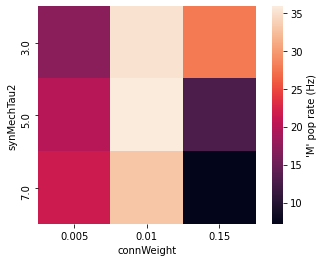

In [ ]:
"""
analysis.py

Functions to read and plot figures from the batch simulation results.
"""

import json
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import pickle
import numpy as np
from pylab import *
from itertools import product
from pprint import pprint
from netpyne import specs
from collections import OrderedDict



#--------------------------------------------------------------------
# Function to read batch data
#--------------------------------------------------------------------
def readBatchData(dataFolder, batchLabel, loadAll=False, saveAll=True, vars=None, maxCombs=None, listCombs=None):
    # load from previously saved file with all data
    if loadAll:
        print('\nLoading single file with all data...')
        filename = '%s/%s/%s_allData.json' % (dataFolder, batchLabel, batchLabel)
        with open(filename, 'r') as fileObj:
            dataLoad = json.load(fileObj, object_pairs_hook=OrderedDict)
        params = dataLoad['params']
        data = dataLoad['data']
        return params, data

    if isinstance(listCombs, str):
        filename = str(listCombs)
        with open(filename, 'r') as fileObj:
            dataLoad = json.load(fileObj)
        listCombs = dataLoad['paramsMatch']

    # read the batch file and cfg
    batchFile = '%s/%s_batch.json' % (dataFolder, batchLabel)
    with open(batchFile, 'r') as fileObj:
        b = json.load(fileObj)['batch']

    # read params labels and ranges
    params = b['params']

    # reorder so grouped params come first
    preorder = [p for p in params if 'group' in p and p['group']]
    for p in params:
        if p not in preorder: preorder.append(p)
    params = preorder

    # read vars from all files - store in dict
    if b['method'] == 'grid':
        labelList, valuesList = list(zip(*[(p['label'], p['values']) for p in params]))
        valueCombinations = product(*(valuesList))
        indexCombinations = product(*[list(range(len(x))) for x in valuesList])
        data = {}
        print('Reading data...')
        missing = 0
        for i,(iComb, pComb) in enumerate(zip(indexCombinations, valueCombinations)):
            if (not maxCombs or i<= maxCombs) and (not listCombs or list(pComb) in listCombs):
                print(i, iComb)
                # read output file
                iCombStr = ''.join([''.join('_'+str(i)) for i in iComb])
                simLabel = b['batchLabel']+iCombStr
                outFile = b['saveFolder']+'/'+simLabel+'.json'
                try:
                    with open(outFile, 'r') as fileObj:
                        output = json.load(fileObj, object_pairs_hook=OrderedDict)
                    # save output file in data dict
                    data[iCombStr] = {}
                    data[iCombStr]['paramValues'] = pComb  # store param values
                    if not vars: vars = list(output.keys())

                    for key in vars:
                        if isinstance(key, tuple):
                            container = output
                            for ikey in range(len(key)-1):
                                container = container[key[ikey]]
                            data[iCombStr][key[1]] = container[key[-1]]

                        elif isinstance(key, str):
                            data[iCombStr][key] = output[key]

                except:
                    print('... file missing')
                    missing = missing + 1
                    output = {}
            else:
                missing = missing + 1

        print('%d files missing' % (missing))

        # save
        if saveAll:
            print('Saving to single file with all data')
            filename = '%s/%s_allData.json' % (dataFolder, batchLabel)
            dataSave = {'params': params, 'data': data}
            with open(filename, 'w') as fileObj:
                json.dump(dataSave, fileObj)

        return params, data

#--------------------------------------------------------------------
# Function to convert data to Pandas
#--------------------------------------------------------------------
def toPandas(params, data):
    if 'simData' in data[list(data.keys())[0]]:
        rows = [list(d['paramValues'])+[s for s in list(d['simData'].values())] for d in list(data.values())]
        cols = [str(d['label']) for d in params]+[s for s in list(data[list(data.keys())[0]]['simData'].keys())]
    else:
        rows = [list(d['paramValues'])+[s for s in list(d.values())] for d in list(data.values())]
        cols = [str(d['label']) for d in params]+[s for s in list(data[list(data.keys())[0]].keys())]

    df = pd.DataFrame(rows, columns=cols)
    df['simLabel'] = list(data.keys())

    colRename=[]
    for col in list(df.columns):
        if col.startswith("[u'"):
            colName = col.replace(", u'","_'").replace("[u","").replace("'","").replace("]","").replace(", ","_")
            colRename.append(colName)
        else:
            colRename.append(col)
    #print(colRename)
    df.columns = colRename

    return df

#--------------------------------------------------------------------
# Function to colors and style of figures
#--------------------------------------------------------------------
def setPlotFormat(numColors=8):
    plt.style.use('seaborn-whitegrid')

    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 'large'

    NUM_COLORS = numColors
    colormap = plt.get_cmap('nipy_spectral')
    colorlist = [colormap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

    plt.rc('axes', prop_cycle=(cycler('color', colorlist)))


#--------------------------------------------------------------------
# Function to plot relation between parameters (tau2 and weight) and firing rate
#--------------------------------------------------------------------
def plot2DRate(dataFolder, batchLabel, params, data, par1, par2, val, valLabel, graphType='matrix', saveFile=None):
    df = toPandas(params, data)
    # dfpop = dfPopRates(df1, 7)

    dfpop = df.iloc[:,0:5] # get param columns of all rows
    # dfpop['simLabel'] = df['simLabel']
    for k in list(df.popRates[0].keys()): dfpop[k] = [r[k] for r in df.popRates]
    #return dfpop

    #print(dfpop)
    # if not valLabel: valLabel = val
    dfsubset = dfpop[[par1,par2,val]]
        # dfgroup = dfsubset.groupby(by=[par1,par2])
        # if groupStat=='first':
        #     dfgroup2 = dfgroup.first()
        # elif groupStat=='last':
        #     dfgroup2 = dfgroup.last()
        # elif groupStat=='mean':
        #     dfgroup2 = dfgroup.mean()
        # elif groupStat=='sum':
        #     dfgroup2 = dfgroup.sum()
        # dffinal = pd.DataFrame(dfgroup2).reset_index()

    dfpiv = pd.pivot_table(dfsubset, index=par1, columns=par2, values=val)
#    pandas.pivot_table(df,values='count',index='site_id',columns='week')
    if graphType=='matrix':
        sb.heatmap(dfpiv, square=True, cbar_kws={'label': valLabel})
    elif graphType=='line':
        setPlotFormat(numColors = len(dfpiv.columns))
        #dfpiv = dfpiv[['IT2','IT4','IT5A','IT5B','PT5B','IT6','CT6']]
        dfpiv.plot(marker='o')
    try:
        if saveFile:
            plt.savefig(saveFile)
        else:
            plt.savefig(dataFolder+'/'+batchLabel+'_matrix_'+par1+'_'+par2+'_'+val+'.png')
    except:
        print('Error saving figure...')

    plt.show()

#--------------------------------------------------------------------
# Function to read batch data and plot figure
#--------------------------------------------------------------------
def readPlot():
    dataFolder = 'tut8_data/'
    batchLabel = 'tauWeight'

    params, data = readBatchData(dataFolder, batchLabel, loadAll=0, saveAll=1, vars=None, maxCombs=None)
    plot2DRate(dataFolder, batchLabel, params, data, 'synMechTau2', 'connWeight', 'M', "'M' pop rate (Hz)")


# Main code
if __name__ == '__main__':
    readPlot()
